In [1]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type and the value must contains year, month, day, hour, minute, and second. 

In [2]:
bigdata = pd.read_csv('./data/two_turkey_vultures_fallmigration.csv', sep=',',header=0)
bigdata['timestamp'] = pd.to_datetime(bigdata.timestamp)
print('total number of gps points:', bigdata.shape[0])
print('unique id:', bigdata['individual_local_identifier'].unique())

total number of gps points: 929
unique id: ['Desert_Rat' 'Julie']


In [3]:
bigdata.head()

,tag_local_identifier,individual_local_identifier,event_id,timestamp,longitude,latitude,migration_state,stepLength,duration,speed
0,127772,Desert_Rat,256965102,2013-10-02 08:00:00,-112.41033,32.02650,FallMigration,0.000000,1.0,0.000000
1,127772,Desert_Rat,256965103,2013-10-02 09:00:00,-112.42383,31.97167,FallMigration,6.228309,1.0,6.228309
2,127772,Desert_Rat,256965104,2013-10-02 10:00:00,-112.55933,31.84333,FallMigration,19.163693,1.0,19.163693
3,127772,Desert_Rat,256965105,2013-10-02 11:00:00,-112.56483,31.72867,FallMigration,12.760204,1.0,12.760204
4,127772,Desert_Rat,256965106,2013-10-02 12:00:00,-112.52167,31.63583,FallMigration,11.101806,1.0,11.101806


# Convert longitude latitude to epsg:3857
If tracking data are already in projected coordinate system, users can skip this step. Otherwise, longitude and latitude coordinates need to be converted to projected coordinate system coordinates. We recommend using the epsg:3857 projected coordinate system because it is used for rendering maps in many common apps such as Google Maps, OpenStreetMap, etc.

In [4]:
!pip install pyproj fastkml shapely

In [5]:
%%time
import pyproj
from fastkml import kml
from shapely.geometry import Point
from shapely.ops import transform

p = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

def convert_to_projected(x, lat, lon):
    point = Point(float(x[lon]), float(x[lat]))
    projected_point = transform(p.transform, point)
    x[lat], x[lon] = projected_point.y, projected_point.x
    return x

bigdata = bigdata.apply(lambda x: convert_to_projected(x, 'latitude', 'longitude'), axis=1)

CPU times: user 385 ms, sys: 67.5 ms, total: 452 ms
Wall time: 471 ms


In [6]:
bigdata.head()

,tag_local_identifier,individual_local_identifier,event_id,timestamp,longitude,latitude,migration_state,stepLength,duration,speed
0,127772,Desert_Rat,256965102,2013-10-02 08:00:00,-1.251346e+07,3.766790e+06,FallMigration,0.000000,1.0,0.000000
1,127772,Desert_Rat,256965103,2013-10-02 09:00:00,-1.251496e+07,3.759592e+06,FallMigration,6.228309,1.0,6.228309
2,127772,Desert_Rat,256965104,2013-10-02 10:00:00,-1.253005e+07,3.742763e+06,FallMigration,19.163693,1.0,19.163693
3,127772,Desert_Rat,256965105,2013-10-02 11:00:00,-1.253066e+07,3.727747e+06,FallMigration,12.760204,1.0,12.760204
4,127772,Desert_Rat,256965106,2013-10-02 12:00:00,-1.252586e+07,3.715602e+06,FallMigration,11.101806,1.0,11.101806


# Initializing ORTEGA object
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In [7]:
interaction1 = ortega.ORTEGA(data=bigdata,
#                              start_time='2020-01-01 00:00:00',  ##set a time window to subset data
#                              end_time='2020-01-10 00:00:00',
                             minute_delay=120,
                             time_field='timestamp',
                             id_field='individual_local_identifier',
                             max_el_time_min=60,
                             speed_average=True
                             )

2023-03-21 10:28:37.900093 Initializing ORTEGA object...
2023-03-21 10:28:37.904897 Generate PPA list for the two moving entities...
2023-03-21 10:28:38.172856 Generating PPA list completed!
2023-03-21 10:28:38.173103 Initialization success!


# Implement interaction analysis

The below cell runs interaction_analysis() and it returns three values. 
- The first value is a list of intersecting PPA pairs as paired built-in Ellipse objects.
- The second return value is a dataframe containing all intersecting PPA pairs. 
- The third return value is a dataframe that includes all identified continuous interaction segments (interaction events).

In [8]:
intersecting_ellipse_list, df_intersecting_PPAs, df_duration = interaction1.interaction_analysis()

2023-03-21 10:28:43.494341 Implement interaction analysis...
2023-03-21 10:28:43.494444 Getting spatial and temporal intersection pairs...
2023-03-21 10:28:44.289961 Getting spatial and temporal intersection pairs completed!
2023-03-21 10:28:44.290330 Complete! 16 pairs of intersecting PPAs found!
2023-03-21 10:28:44.294661 Compute duration of interaction...
2023-03-21 10:28:44.306001 Complete! 3 interaction events identified!


The beblow results indicate 10 interaction events between these two moving entities.
The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [9]:
df_duration

,No,P1,P2,Start,End,Duration
0,1,Desert_Rat,Julie,2013-10-07 09:00:00,2013-10-07 15:00:00,360.0
1,2,Desert_Rat,Julie,2013-10-08 08:00:00,2013-10-08 15:00:00,420.0
2,3,Desert_Rat,Julie,2013-10-09 11:00:00,2013-10-09 15:00:00,240.0


# Compute PPA size and use violin plots to show the distribution

In [10]:
ppasize_list = interaction1.compute_ppa_size()

Descriptive statistics of PPA ellipses length for id Desert_Rat:
count       252.000000
mean      51809.519680
std       47224.033066
min          56.823702
25%        2141.302673
50%       42866.433381
75%       92602.186155
max      198787.185288
dtype: float64
Descriptive statistics of PPA ellipses length for id Julie:
count       512.000000
mean      42746.771258
std       42774.315304
min          56.823702
25%        1729.376990
50%       27780.129045
75%       76631.623467
max      162066.030943
dtype: float64


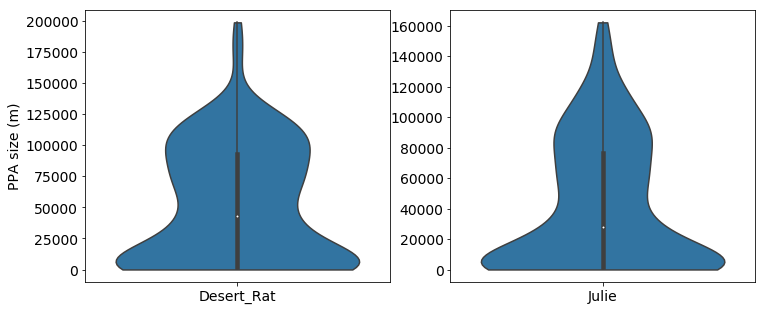

In [11]:
import seaborn
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=ppasize_list[0], ax=ax1,cut=0)
seaborn.violinplot(data=ppasize_list[1], ax=ax2,cut=0)
ax1.set_xticklabels([str(interaction1.id1)])
ax2.set_xticklabels([str(interaction1.id2)])
ax1.set_ylabel('PPA size (m)')
# ax2.set_ylabel('PPA size (m)')
plt.show()

# Compute PPA interval and use violin plot to show the distribution

In [12]:
interval_list = interaction1.compute_ppa_interval()

Descriptive statistics of PPA ellipses time interval (minutes) for id Desert_Rat:
count    277.0
mean      60.0
std        0.0
min       60.0
25%       60.0
50%       60.0
75%       60.0
max       60.0
Name: timestamp, dtype: float64
Descriptive statistics of PPA ellipses time interval (minutes) for id Julie:
count    595.0
mean      60.0
std        0.0
min       60.0
25%       60.0
50%       60.0
75%       60.0
max       60.0
Name: timestamp, dtype: float64


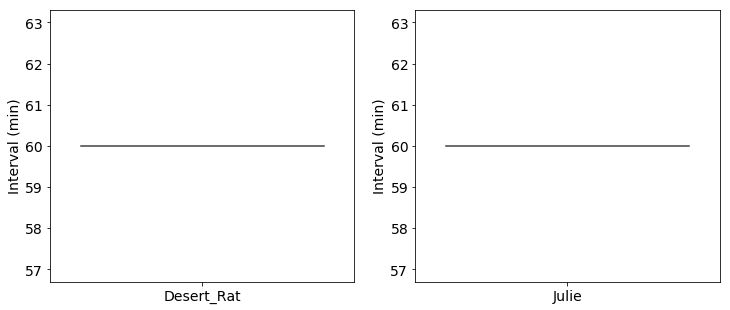

In [13]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
seaborn.violinplot(data=interval_list[0].tolist(), ax=ax1,cut=0)
seaborn.violinplot(data=interval_list[1].tolist(), ax=ax2,cut=0)
ax1.set_xticklabels([interaction1.id1])
ax2.set_xticklabels([interaction1.id2])
ax1.set_ylabel('Interval (min)')
ax2.set_ylabel('Interval (min)')
plt.show()

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

In [14]:
import matplotlib.patches as mpatches
import geopandas as gpd

interaction_color = "#f2ff00"  # yellow
colors = ["#ff0000", "#0000ff"]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(epsg=3857)

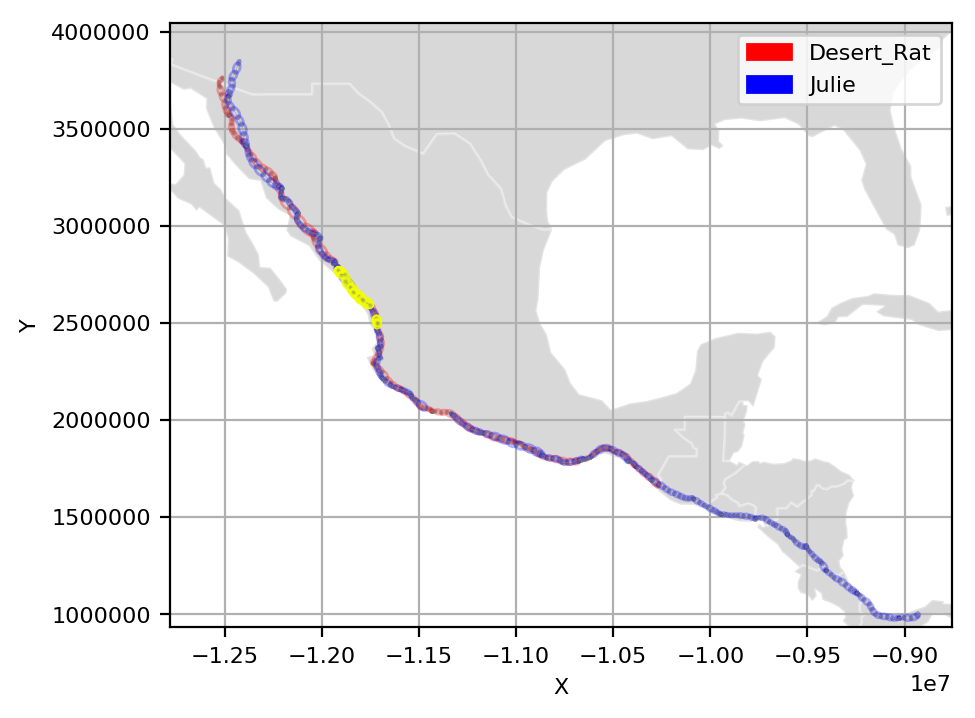

In [15]:
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(dpi=200)
base = world.plot(ax=ax, color='gray', edgecolor='white',alpha=0.3)
for i, collection in enumerate([interaction1.ellipses_list_id1, interaction1.ellipses_list_id2]):
    color_picked = colors[i]
    for item in collection:
        x, y = item.el.xy
        plt.plot(y, x, color=color_picked, alpha=0.3, linewidth=1, solid_capstyle="round")
        # PLOT THE POINTS USED TO MAKE THE ELLIPSES, TOO
        plt.plot([item.lon, item.last_lon], [item.lat, item.last_lat], ".-", color="grey", alpha=0.3, linewidth=0.5,
                 markersize=1)

for two_item in intersecting_ellipse_list:
    for item in two_item:
        x1, y1 = item.el.xy
        plt.plot(y1, x1, color=interaction_color, alpha=0.8, linewidth=2, solid_capstyle="round")
        plt.plot([item.lon, item.last_lon], [item.lat, item.last_lat], ".-", color="grey", alpha=0.3, linewidth=0.5,
                 markersize=1)
plt.xlabel("X")#, fontsize=14
plt.ylabel("Y")
ax.set_xlim([bigdata['longitude'].min()*1.02,bigdata['longitude'].max()/1.02])
ax.set_ylim([bigdata['latitude'].min()/1.05,bigdata['latitude'].max()*1.05])
plt.legend(handles=[mpatches.Patch(color=colors[0], label=interaction1.id1),
                        mpatches.Patch(color=colors[1], label=interaction1.id2)])
plt.rcParams.update({'font.size': 6})
plt.grid(True)

# Explore the difference in speed and movement  direction when individuals interact

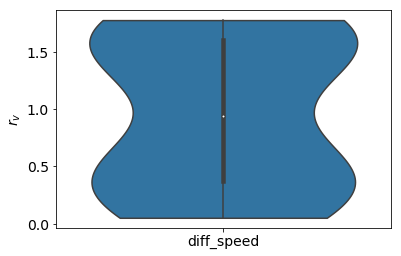

In [16]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_speed'].tolist(),cut=0)
ax.set_xticklabels(['diff_speed'])
ax.set_ylabel(r'$r_v$')
plt.show()

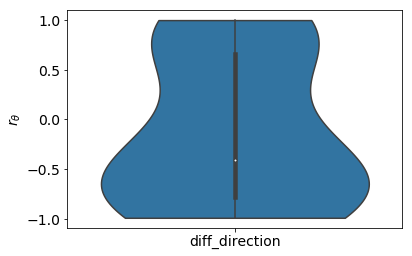

In [17]:
plt.rcParams.update({'font.size': 14})
ax = seaborn.violinplot(data=df_intersecting_PPAs['diff_direction'].tolist(),cut=0)
ax.set_xticklabels(['diff_direction'])
ax.set_ylabel(r'$r_\theta$')
plt.show()